# GSAT by IPCC regions

In [1]:
import timeit
import zipfile
import requests
import json

from utils import find_region, find_region_bbox

import numpy as np
import pandas as pd
import netCDF4
import xarray
import dask

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
%matplotlib inline

In [3]:
dask.config.set(scheduler="processes")

plt.rcParams["figure.figsize"] = 12, 6

## Introduction

## IPCC regions

The IPCC AR6 reference regions are standardized spatial domains defined for climate model evaluation and communication of regional climate change information. They’re used in the Atlas chapter of the AR6 Working Group I Report and are available as shapefiles or GeoJSON data.

In [4]:
regions_url = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/refs/heads/main/reference-regions/IPCC-WGI-reference-regions-v4.geojson"
regions_file = regions_url.split("/")[-1]

with open(regions_file, "w") as f:
    r = requests.get(regions_url)
    r.raise_for_status()
    f.write(r.text)

with open(regions_file, "r") as f:
    regions = json.load(f)

IPCC AR6 reference regions include:

- Land regions (e.g., WCE — Western Central Europe, EAS — East Asia)
- Marine regions (e.g., NPO — North Pacific Ocean)
- Combined “reference regions” for climate impact assessments

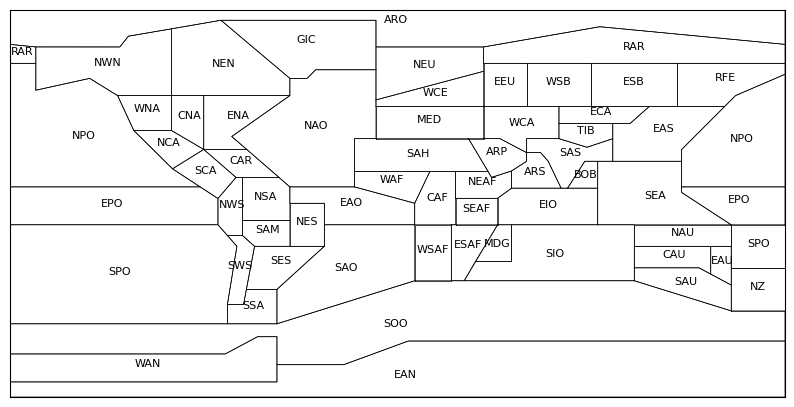

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(
    llcrnrlon=-180, urcrnrlon=180,
    llcrnrlat=-90, urcrnrlat=90,
    resolution="i", ax=ax)

def plot_polygon(coordinates, text, **kwargs):
    for polygon in coordinates:
        x, y = zip(*polygon)
        x, y = m(x, y)  # convert to map projection
        m.plot(x, y, marker=None, **kwargs)

        flat_coords = [point for ring in coordinates for point in ring]
        avg_lon = sum(point[0] for point in flat_coords) / len(flat_coords)
        avg_lat = sum(point[1] for point in flat_coords) / len(flat_coords)
        cx, cy = m(avg_lon, avg_lat)
        ax.text(cx, cy, text, fontsize=8, ha="center", color="black")

for feature in regions["features"]:
    geometry = feature["geometry"]
    geom_type = geometry["type"]
    label = feature["properties"]["Acronym"]

    if geom_type == "Polygon":
        plot_polygon(geometry["coordinates"], label, color="black", lw=.5)

    elif geom_type == "MultiPolygon":
        for polygon in geometry["coordinates"]:
            plot_polygon(polygon, label, color="black", lw=.5)

In [6]:
region = find_region("SAH", regions)
bbox = find_region_bbox(region)
print(region["properties"])

{'id': '20', 'Continent': 'AFRICA', 'Type': 'Land', 'Name': 'Sahara', 'Acronym': 'SAH'}


Plot the region of interest.

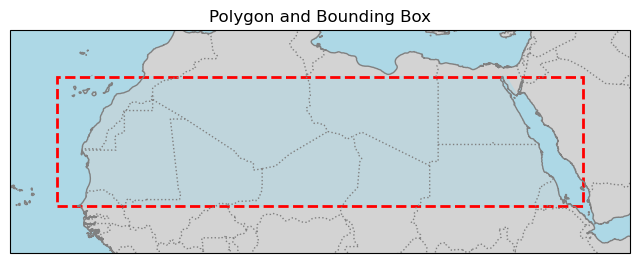

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot polygon
coords = region["geometry"]["coordinates"][0]
poly_patch = Polygon(coords, closed=True, fill=True, color="lightblue", alpha=.5)
ax.add_patch(poly_patch)

# Plot bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                 linewidth=2, edgecolor="red", facecolor="none", linestyle="--")
ax.add_patch(rect)

# Add labels and grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Polygon and Bounding Box")
ax.grid(True)

# Adjust plot limits
ax.set_xlim(bbox[0] - 5.5, bbox[2] + 5.5)
ax.set_ylim(bbox[1] - 5.5, bbox[3] + 5.5)

ax.coastlines(resolution="10m", color="gray")
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

plt.show()

## GSAT for the IPCC region

In [8]:
query = (
    'variable == "tas" & '
    'table == "Amon" & '
    '(experiment == "historical" | experiment == "ssp585") & '
    'replica == "esgf.ceda.ac.uk"')

catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("").query(query)

catalog["dataset_id"] = catalog[
    ["project", "product", "institution", "model", "experiment", "table", "variable", "grid_label", "version"]
].agg(".".join, axis=1)

/tmp/ipykernel_723577/211782750.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("").query(query)


In [9]:
url = catalog[catalog["dataset_id"] == "CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.Amon.tas.gr.v20200310"]["location"].iloc[0]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_EC-Earth-Consortium_EC-Earth3_ssp585_Amon_gr_v20200310/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_EC-Earth-Consortium_EC-Earth3_ssp585_Amon_tas_gr_v20200310.ncml'

In [10]:
ds = xarray.open_dataset(url)
ds

<xarray.Dataset> Size: 541MB
Dimensions:           (lat: 256, bnds: 2, lon: 512, time: 1032,
                       variant_label: 1, nfiles: 86, file: 2)
Coordinates:
  * lat               (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.77 89.46
  * lon               (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
    height            float64 8B ...
  * time              (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-...
  * variant_label     (variant_label) |S64 64B b'r1i1p1f1'
Dimensions without coordinates: bnds, nfiles, file
Data variables:
    lat_bnds          (lat, bnds) float64 4kB ...
    lon_bnds          (lon, bnds) float64 8kB ...
    time_bnds         (time, bnds) datetime64[ns] 17kB ...
    further_info_url  (nfiles, file) |S64 11kB ...
    tracking_id       (nfiles, file) |S64 11kB ...
    tas               (variant_label, time, lat, lon) float32 541MB ...
Attributes: (12/53)
    Conventions:            
    activity_id:            ScenarioMIP
    branch_method:          no parent
    branch_time:            0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    size:                   405874019
    size_human:             387.1 MiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    version:                v20200310
    replica:                1

In [11]:
ds180 = ds["tas"].assign_coords(lon=(((ds["tas"].coords["lon"] + 180) % 360) - 180))
ds180 = ds180.sortby(ds180.coords["lon"])
ds180

<xarray.DataArray 'tas' (variant_label: 1, time: 1032, lat: 256, lon: 512)> Size: 541MB
[135266304 values with dtype=float32]
Coordinates:
  * lat            (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
    height         float64 8B ...
  * time           (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-...
  * variant_label  (variant_label) |S64 64B b'r1i1p1f1'
  * lon            (lon) float64 4kB -180.0 -179.3 -178.6 ... 177.9 178.6 179.3
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2019-09-27T23:26:29Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1 256 512]

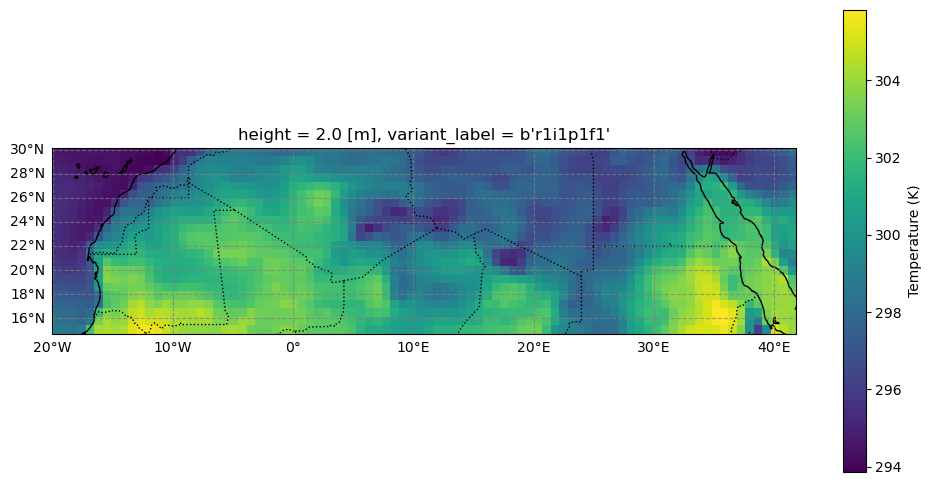

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

plot = ds180.isel(variant_label=0) \
    .sel(lat=slice(bbox[1], bbox[3])).load() \
    .sel(lon=slice(bbox[0], bbox[2])) \
    .mean("time") \
    .plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature (K)'})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.3)

# Optional: zoom to your bounding box
# ax.set_extent(bbox, crs=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.7)
gl.top_labels = False   # remove top x labels
gl.right_labels = False # remove right y labels
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

# Add axis labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

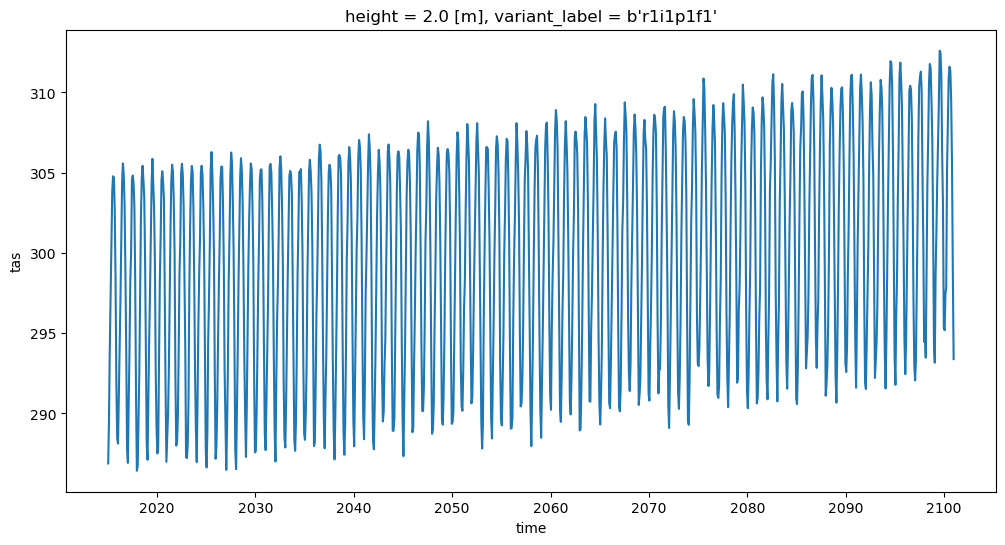

In [13]:
fig, ax = plt.subplots()

plot = ds180.isel(variant_label=0) \
    .sel(lat=slice(bbox[1], bbox[3])).load() \
    .sel(lon=slice(bbox[0], bbox[2])) \
    .mean(["lat", "lon"]) \
    .plot(ax=ax)

plt.show()